In [1]:
!pip install pandas
!pip install accelerate
!pip install transformers
import accelerate
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import TensorDataset
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving PromiseEval_Sample_Trainset_English.json to PromiseEval_Sample_Trainset_English.json
Saving PromiseEval_Trainset_English.json to PromiseEval_Trainset_English.json


In [3]:
import pandas as pd

json_file1 = '/content/PromiseEval_Sample_Trainset_English.json'
json_file2=  '/content/PromiseEval_Trainset_English.json'
csv_file = '/content/data.csv'  # Replace with your desired CSV file name

# Read the JSON file
df1 = pd.read_json(json_file1)
df2 = pd.read_json(json_file2)

# Concatenate the DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Convert to CSV
df.to_csv(csv_file, index=False)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df['promise_status'] = df['promise_status'].replace({'Yes': 1, 'No': 0})
df['evidence_status'] = df['evidence_status'].replace({'Yes': 1, 'No': 0})
print(f'JSON has been successfully converted to CSV: {csv_file}')


JSON has been successfully converted to CSV: /content/data.csv


<ipython-input-3-09dbd61cf581>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
<ipython-input-3-09dbd61cf581>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['promise_status'] = df['promise_status'].replace({'Yes': 1, 'No': 0})
<ipython-input-3-09dbd61cf581>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['evidence_status'] = df['evidence_status'].replace({'Yes': 1, 'No': 0})


In [4]:
ver_df = df.copy()
qua_df = df.copy()
df

,URL,page_number,data,promise_status,verification_timeline,evidence_status,evidence_quality
0,https://r.lvmh-static.com/uploads/2023/06/06-2...,10,“LVMH is transforming the luxury industry.”PRO...,0,N/A,0,N/A
1,https://r.lvmh-static.com/uploads/2023/06/06-2...,13,“Each of us has the teams required to achieve ...,0,N/A,0,N/A
2,https://r.lvmh-static.com/uploads/2023/06/06-2...,14,“The LVMH Prize has allowed me to help change ...,0,N/A,0,N/A
3,https://r.lvmh-static.com/uploads/2023/06/06-2...,15,“LVMH shows an extraordinary level of commitme...,0,N/A,0,N/A
4,https://r.lvmh-static.com/uploads/2023/06/06-2...,16,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,N/A,0,N/A
...,...,...,...,...,...,...,...
595,https://www.baytexenergy.com/content/uploads/2...,29,Continual improvement We follow up on high-pot...,1,Already,1,Not Clear
596,https://www.baytexenergy.com/content/uploads/2...,29,Emergency preparedness We maintain and rehears...,1,Already,1,Clear
597,https://www.baytexenergy.com/content/uploads/2...,80,The climate policies and regulations most rele...,0,N/A,0,N/A
598,https://www.baytexenergy.com/content/uploads/2...,80,SENSITIVITY ANALYSIS As part of the scenario a...,1,More than 5 years,1,Clear


In [5]:
ver_df = ver_df.drop('page_number', axis=1)
ver_df = ver_df.drop('URL', axis=1)
ver_df = ver_df.drop('evidence_status', axis=1)
ver_df = ver_df.drop('evidence_quality', axis=1)

ver_df['verification_timeline'] = ver_df['verification_timeline'].str.strip()
df_bin = pd.get_dummies(ver_df['verification_timeline'])
vdf_final = pd.concat([ver_df, df_bin], axis=1)
vdf_final = vdf_final.drop('verification_timeline', axis=1)
bool_cols = vdf_final.select_dtypes(include='bool').columns
vdf_final[bool_cols] = vdf_final[bool_cols].astype(int)
vdf_final

,data,promise_status,2 to 5 years,Already,Less than 2 years,More than 5 years,N/A
0,“LVMH is transforming the luxury industry.”PRO...,0,0,0,0,0,1
1,“Each of us has the teams required to achieve ...,0,0,0,0,0,1
2,“The LVMH Prize has allowed me to help change ...,0,0,0,0,0,1
3,“LVMH shows an extraordinary level of commitme...,0,0,0,0,0,1
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
595,Continual improvement We follow up on high-pot...,1,0,1,0,0,0
596,Emergency preparedness We maintain and rehears...,1,0,1,0,0,0
597,The climate policies and regulations most rele...,0,0,0,0,0,1
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,0,0,0,1,0


In [6]:
unique_counts = qua_df['evidence_status'].value_counts()
# unique_counts

In [7]:
qua_df = qua_df.drop('page_number', axis=1)
qua_df = qua_df.drop('URL', axis=1)
qua_df = qua_df.drop('verification_timeline', axis=1)

qua_df['evidence_quality'] = qua_df['evidence_quality'].str.strip()
df_bin = pd.get_dummies(qua_df['evidence_quality'])
qdf_final = pd.concat([qua_df, df_bin], axis=1)
qdf_final = qdf_final.drop('evidence_quality', axis=1)
bool_cols = qdf_final.select_dtypes(include='bool').columns
qdf_final[bool_cols] = qdf_final[bool_cols].astype(int)
qdf_final

,data,promise_status,evidence_status,Clear,Misleading,N/A,Not Clear
0,“LVMH is transforming the luxury industry.”PRO...,0,0,0,0,1,0
1,“Each of us has the teams required to achieve ...,0,0,0,0,1,0
2,“The LVMH Prize has allowed me to help change ...,0,0,0,0,1,0
3,“LVMH shows an extraordinary level of commitme...,0,0,0,0,1,0
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0,0,0,1,0
...,...,...,...,...,...,...,...
595,Continual improvement We follow up on high-pot...,1,1,0,0,0,1
596,Emergency preparedness We maintain and rehears...,1,1,1,0,0,0
597,The climate policies and regulations most rele...,0,0,0,0,1,0
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,1,1,0,0,0


In [8]:
qdf_final.to_csv('/content/qdata.csv' , index=False)
vdf_final.to_csv('/content/vdata.csv' , index=False)

In [9]:
label_df = qdf_final[['data','promise_status','evidence_status']]
label_df

,data,promise_status,evidence_status
0,“LVMH is transforming the luxury industry.”PRO...,0,0
1,“Each of us has the teams required to achieve ...,0,0
2,“The LVMH Prize has allowed me to help change ...,0,0
3,“LVMH shows an extraordinary level of commitme...,0,0
4,GROUP-WIDE OVERSIGHT BODIES The Board-level Et...,0,0
...,...,...,...
595,Continual improvement We follow up on high-pot...,1,1
596,Emergency preparedness We maintain and rehears...,1,1
597,The climate policies and regulations most rele...,0,0
598,SENSITIVITY ANALYSIS As part of the scenario a...,1,1


In [10]:
train_df = label_df[:420]
validation_df = label_df[420:500]
test_df = label_df[500:]
train_labels_df = label_df[:420]
validation_labels_df = label_df[420:500]
test_labels_df = label_df[500:]

In [11]:
train_sentences = train_df['data'].values.tolist()
train_labels = train_labels_df.iloc[:, 1:].values
train_labels = train_labels.astype(np.float32)

validation_sentences = validation_df['data'].values.tolist()
validation_labels = validation_labels_df.iloc[:, 1:].values
validation_labels = validation_labels.astype(np.float32)

In [19]:
# from transformers import AutoTokenizer

# checkpoint = "xlm-roberta-base"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=2, problem_type="multi_label_classification")
# model

from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, problem_type="multi_label_classification")
model

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [13]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=".",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    num_train_epochs = 8,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    learning_rate = 8e-6,
    warmup_steps = 30,
     report_to=[],
    logging_steps= 100,
    metric_for_best_model="f1"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
class ArgDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_encodings = tokenizer(train_sentences, padding = True, truncation = True, max_length = 512)
train_dataset = ArgDataset(train_encodings, train_labels)

validation_encodings = tokenizer(validation_sentences, padding = True, truncation = True, max_length = 512)
validation_dataset = ArgDataset(validation_encodings, validation_labels)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

label_names = train_labels_df.columns[1:].tolist()

def compute_metrics(pred):
    labels = pred.label_ids
    preds = (pred.predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)

    # Generate classification report
    # report = classification_report(labels, preds, target_names=label_names, zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'classification_report': report
    }


In [17]:
import os

os.environ["WANDB_DISABLED"] = "true"

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.482300,0.514664,0.587500,0.764407,0.920792,0.829762
2,0.494100,0.511977,0.687500,0.816032,0.930693,0.865614
3,0.428700,0.569130,0.737500,0.820497,0.950495,0.880430
4,0.332300,0.522024,0.700000,0.844000,0.900990,0.869548
5,0.213500,0.550660,0.662500,0.869040,0.861386,0.857922
6,0.196900,0.619115,0.725000,0.849822,0.891089,0.868547
7,0.163000,0.633590,0.712500,0.846149,0.900990,0.869798
8,0.127000,0.658193,0.712500,0.842534,0.891089,0.864431


TrainOutput(global_step=1680, training_loss=0.31469771862030027, metrics={'train_runtime': 1099.2021, 'train_samples_per_second': 3.057, 'train_steps_per_second': 1.528, 'total_flos': 884069000478720.0, 'train_loss': 0.31469771862030027, 'epoch': 8.0})

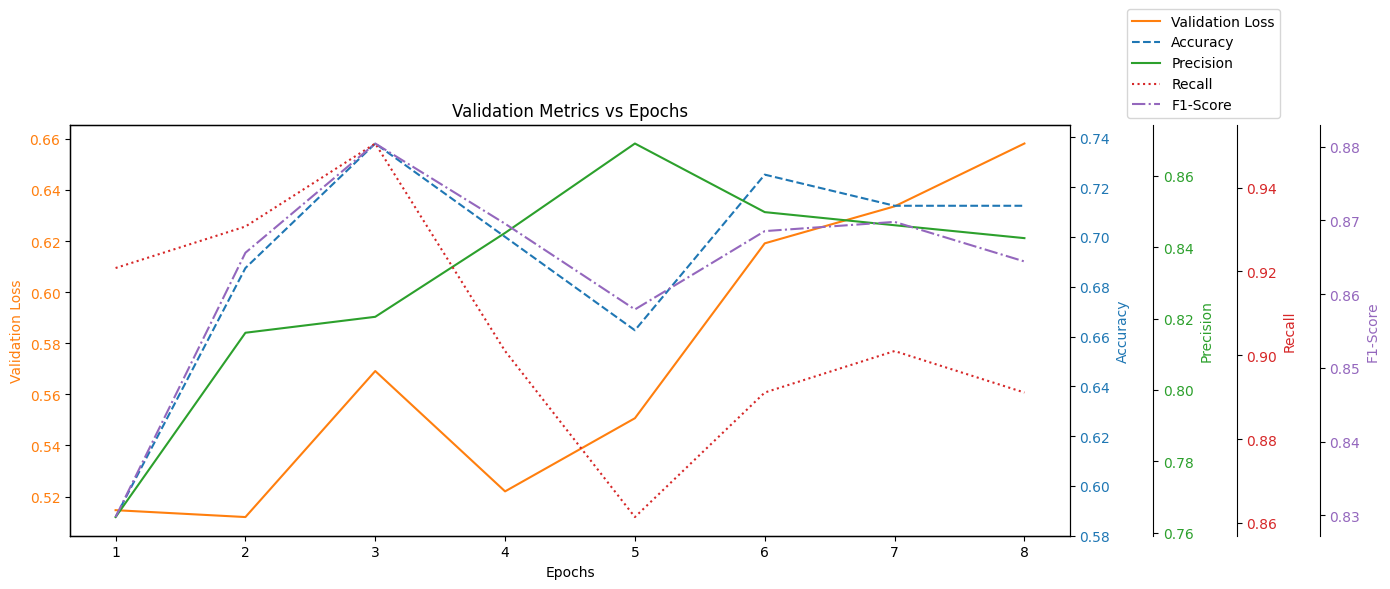

In [21]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Initialize lists for storing values
losses = []
accuracies = []
precisions = []
f1_scores = []
recalls = []

# Parse through the log history and extract values
for entry in log_history:
    if 'eval_loss' in entry and 'eval_accuracy' in entry and 'eval_precision' in entry and 'eval_recall' in entry and 'eval_f1' in entry:
        losses.append(entry['eval_loss'])
        accuracies.append(entry['eval_accuracy'])
        precisions.append(entry['eval_precision'])
        f1_scores.append(entry['eval_f1'])
        recalls.append(entry['eval_recall'])

# Define epochs (adjust based on your actual epoch range)
epochs = list(range(1, len(losses) + 1))

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the first metric (loss) on the primary y-axis
ax1.plot(epochs, losses, color='tab:orange', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:orange')

# Create a secondary y-axis for Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs, accuracies, color='tab:blue', linestyle='--', label='Accuracy')
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Create a tertiary y-axis for Precision
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(epochs, precisions, color='tab:green', linestyle='-', label='Precision')
ax3.set_ylabel('Precision', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Create a fourth y-axis for Recall
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Offset the fourth y-axis
ax4.plot(epochs, recalls, color='tab:red', linestyle=':', label='Recall')
ax4.set_ylabel('Recall', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

# Create a fifth y-axis for F1-score
ax5 = ax1.twinx()
ax5.spines['right'].set_position(('outward', 180))  # Offset the fifth y-axis
ax5.plot(epochs, f1_scores, color='tab:purple', linestyle='-.', label='F1-Score')
ax5.set_ylabel('F1-Score', color='tab:purple')
ax5.tick_params(axis='y', labelcolor='tab:purple')

# Add legends for each line
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines5, labels5 = ax5.get_legend_handles_labels()

ax2.legend(lines1 + lines2 + lines3 + lines4 + lines5,
           labels1 + labels2 + labels3 + labels4 + labels5,
           loc='lower left', bbox_to_anchor=(1.05, 1))

# Title and grid
plt.title('Validation Metrics vs Epochs')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


In [22]:
model.save_pretrained("/content/")
model = AutoModelForSequenceClassification.from_pretrained("/content/")

In [23]:
test_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df.insert(0, 'Index', range(1, len(test_labels_df) + 1))
test_labels_df

,Index,data,promise_status,evidence_status
500,1,"Our Commitment We acknowledge that the health,...",1,0
501,2,We are resolute in our commitment to prioritiz...,1,0
502,3,Topic Management All Canada Nickel operations ...,1,1
503,4,Monitoring With our operations currently limit...,1,0
504,5,Permitting and Compliance Canada as an operati...,1,1
...,...,...,...,...
595,96,Continual improvement We follow up on high-pot...,1,1
596,97,Emergency preparedness We maintain and rehears...,1,1
597,98,The climate policies and regulations most rele...,0,0
598,99,SENSITIVITY ANALYSIS As part of the scenario a...,1,1


In [27]:
predictions = []
threshold = 0.65

for idx, row in test_df.iterrows():
    arg_id = row['Index']
    text = row['data']
    encoding = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoding)

    sigmoid = torch.nn.Sigmoid()
    predictions_tensor = sigmoid(outputs.logits)

    predicted_labels = []
    for prob in predictions_tensor.flatten():
        if prob >= threshold:
          label = 1
        else:
          label =  0
        predicted_labels.append(label)

    predictions.append([arg_id] + predicted_labels)

data = {'Index': [entry[0] for entry in predictions]}

for i, label in enumerate(test_labels_df.columns[2:]):
    data[label] = [entry[i+1] for entry in predictions]
predictions_df = pd.DataFrame(data)


In [28]:
true_pred = test_labels_df[['Index','promise_status','evidence_status']]

In [30]:
# prompt: value count in test_labels_df['evidence']

print(test_labels_df['evidence_status'].value_counts())

evidence_status
0    59
1    41
Name: count, dtype: int64


In [31]:
print(predictions_df['evidence_status'].value_counts())

evidence_status
1    53
0    47
Name: count, dtype: int64


In [29]:
# true_labels = true_pred[['promise_status','evidence_status']]
# pred_labels = predictions_df[['promise_status','evidence_status']]

true_labels = true_pred[['evidence_status']]
pred_labels = predictions_df[['evidence_status']]

f1_average = f1_score(true_labels, pred_labels, average='macro')
print(f"Average F1 Score: {f1_average}")

Average F1 Score: 0.800058292043136
